# Import Libraries

In [1]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

# Check if CUDA is available

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


# Data

In [3]:
weight = 0.7
bias = 0.3

start = 0
end = 1
step = 0.02

X = torch.arange(start, end, step).unsqueeze(dim=1)
y = weight * X + bias
X[:10], y[:10]

(tensor([[0.0000],
         [0.0200],
         [0.0400],
         [0.0600],
         [0.0800],
         [0.1000],
         [0.1200],
         [0.1400],
         [0.1600],
         [0.1800]]),
 tensor([[0.3000],
         [0.3140],
         [0.3280],
         [0.3420],
         [0.3560],
         [0.3700],
         [0.3840],
         [0.3980],
         [0.4120],
         [0.4260]]))

# Splitting Data

In [4]:
train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

In [5]:
def plot_prediction(X_train, y_train, X_test, y_test, predictions=None):
    plt.figure(figsize=(10, 6))

    plt.scatter(X_train, y_train, color="blue", label="Training Data")
    plt.scatter(X_test, y_test, color="green", label="Test Data")

    if predictions is not None:
        plt.scatter(X_test, predictions, color="red", marker="x", label="Predictions")

    plt.title("Model Predictions vs Ground Truth")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True)
    plt.show()

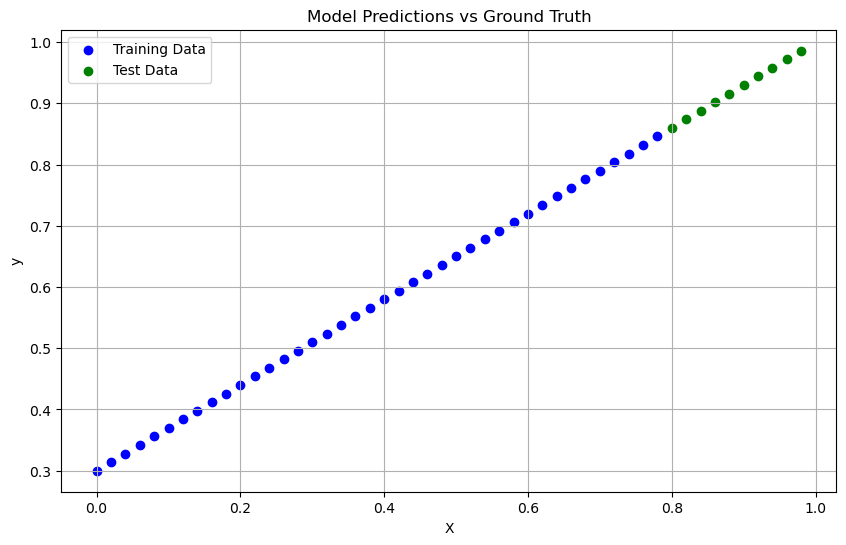

In [6]:
plot_prediction(X_train, y_train, X_test, y_test)

# Building Model 

In [7]:
class LinearRegressionModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)

    def forward(self, x: torch.tensor) -> torch.Tensor:
        return self.linear_layer(x)


# Set Manual Seed

torch.manual_seed(42)
model = LinearRegressionModelV2().to(device)
print(model)
print(model.state_dict())

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)
OrderedDict([('linear_layer.weight', tensor([[0.7645]], device='cuda:0')), ('linear_layer.bias', tensor([0.8300], device='cuda:0'))])


In [8]:
next(model.parameters()).device

device(type='cuda', index=0)

# Setup Loss Function

In [9]:
loss_fn = nn.L1Loss()

# Setup an Optimizer

In [10]:
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

# Putting test data to gpu

In [11]:
X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

# Training Loop

In [12]:
torch.manual_seed(42)
epochs = 200

for epoch in range(epochs):
    model.train()

    # 1. Forward Pass
    y_pred = model(X_train)

    # 2. Calculate the loss
    loss = loss_fn(y_pred, y_train)

    # 3. Optimizer Zero Grad
    optimizer.zero_grad()

    # 4. Perform BackPropagation
    loss.backward()

    # 5. Optimizer Step
    optimizer.step()

    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)

    # Printting
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss: {loss} | test_loss: {test_loss}")

Epoch: 0 | loss: 0.5551779866218567 | test_loss: 0.5739762187004089
Epoch: 10 | loss: 0.439968079328537 | test_loss: 0.4392664134502411
Epoch: 20 | loss: 0.3247582018375397 | test_loss: 0.30455657839775085
Epoch: 30 | loss: 0.20954833924770355 | test_loss: 0.16984669864177704
Epoch: 40 | loss: 0.09433845430612564 | test_loss: 0.03513690456748009
Epoch: 50 | loss: 0.023886388167738914 | test_loss: 0.04784907028079033
Epoch: 60 | loss: 0.019956795498728752 | test_loss: 0.045803118497133255
Epoch: 70 | loss: 0.016517987474799156 | test_loss: 0.037530567497015
Epoch: 80 | loss: 0.013089174404740334 | test_loss: 0.02994490973651409
Epoch: 90 | loss: 0.009653178043663502 | test_loss: 0.02167237363755703
Epoch: 100 | loss: 0.006215683650225401 | test_loss: 0.014086711220443249
Epoch: 110 | loss: 0.00278724217787385 | test_loss: 0.005814164876937866
Epoch: 120 | loss: 0.0012645035749301314 | test_loss: 0.013801801018416882
Epoch: 130 | loss: 0.0012645035749301314 | test_loss: 0.013801801018416

In [13]:
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.6968]], device='cuda:0')),
             ('linear_layer.bias', tensor([0.3025], device='cuda:0'))])

# Plot Predictions

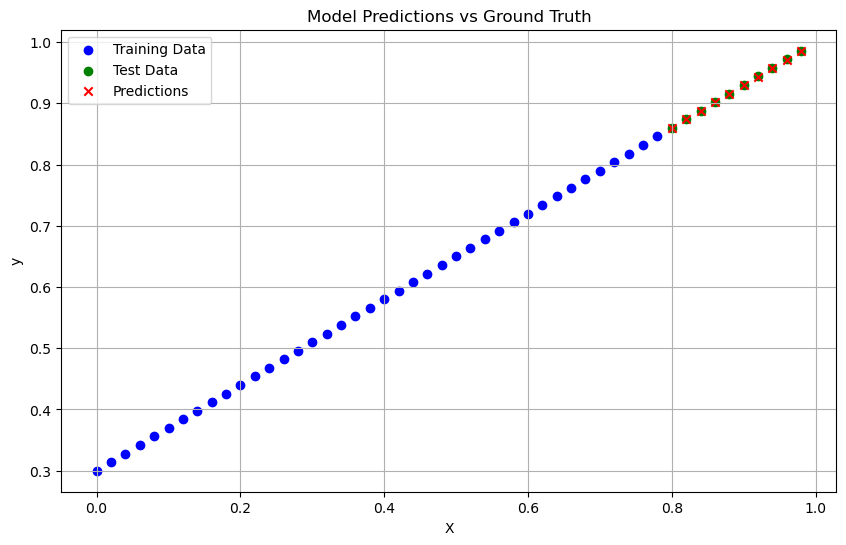

In [14]:
plot_prediction(
    X_train.cpu().numpy(),
    y_train.cpu().numpy(),
    X_test.cpu().numpy(),
    y_test.cpu().numpy(),
    predictions=test_pred.cpu().numpy(),
)

# Saving Model

In [15]:
# Create Model Directory
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

# Create Model save Path
MODEL_NAME = "V2_workflow_workshop.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

# Save Model state dict
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)
print(f"Model is Saved to {MODEL_SAVE_PATH}")

Model is Saved to models/V2_workflow_workshop.pt


# Loading Model

In [16]:
# To load a saved model using its state_dict, we must first re-create the model architecture.
# This creates a new instance of the same model class we originally trained and saved.
loaded_model = LinearRegressionModelV2()

# Load the saved state_dict (i.e., the trained weights and biases) into the new model instance.
# This updates the new model with the parameters learned during training, effectively restoring its state.

loaded_model.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

loaded_model.to(device)

LinearRegressionModelV2(
  (linear_layer): Linear(in_features=1, out_features=1, bias=True)
)